In [3]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

%matplotlib inline

train_features = pd.read_csv('train_features.csv') #train data
test_features = pd.read_csv('test_features.csv') #test data
train_targets_nonscored = pd.read_csv('train_targets_nonscored.csv') #train label template
train_targets_scored = pd.read_csv('train_targets_scored.csv') #train label with values (has a lot of variance)
train_drug = pd.read_csv('train_drug.csv')

def show_df(df, n=4):
    display(df.head(n=n))

print(f'train_features: {train_features.shape}')
print(f'train_targets_nonscored: {train_targets_nonscored.shape}')
print(f'test_features: {test_features.shape}')
print(f'train_targets_scored: {train_targets_scored.shape}')
print(f'train_drug: {train_drug.shape}')


train_features: (23814, 876)
train_targets_nonscored: (23814, 403)
test_features: (3982, 876)
train_targets_scored: (23814, 207)
train_drug: (23814, 2)


In [4]:
print(f'train_features: {train_features.shape}')
show_df(train_features)

print(f'train_targets_scored: {train_targets_scored.shape}')
show_df(train_targets_scored)

print(f'test_features: {test_features.shape}')
show_df(test_features)

print(f'train_targets_nonscored: {train_targets_nonscored.shape}')
show_df(train_targets_nonscored)

train_features: (23814, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154


train_targets_scored: (23814, 207)


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


test_features: (3982, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809


train_targets_nonscored: (23814, 403)


,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


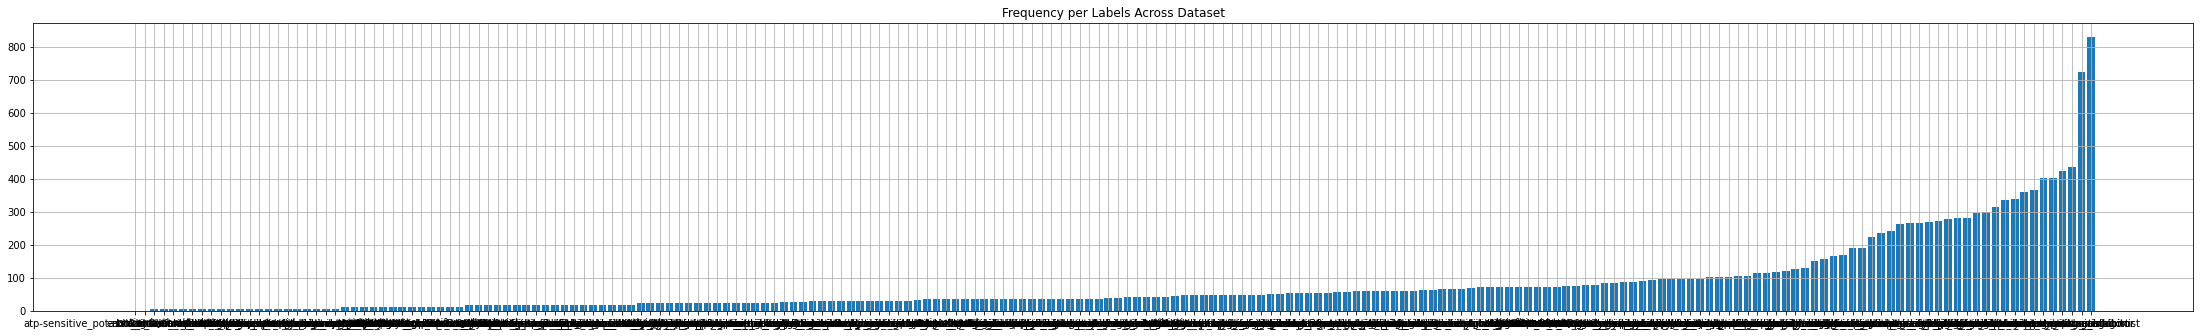

In [5]:
counts = {label: train_targets_scored[label].sum() for label in train_targets_scored.columns if label != 'sig_id' }
counts = {label: count for count in sorted(counts.values()) for label in counts.keys() if counts[label] == count}
label_names = counts.keys()
label_frequency = counts.values()

fig = plt.figure(200)
ax = fig.add_axes([0,0,5,1])
ax.bar(label_names,label_frequency)
plt.grid()
plt.title('Frequency per Labels Across Dataset')
plt.show()

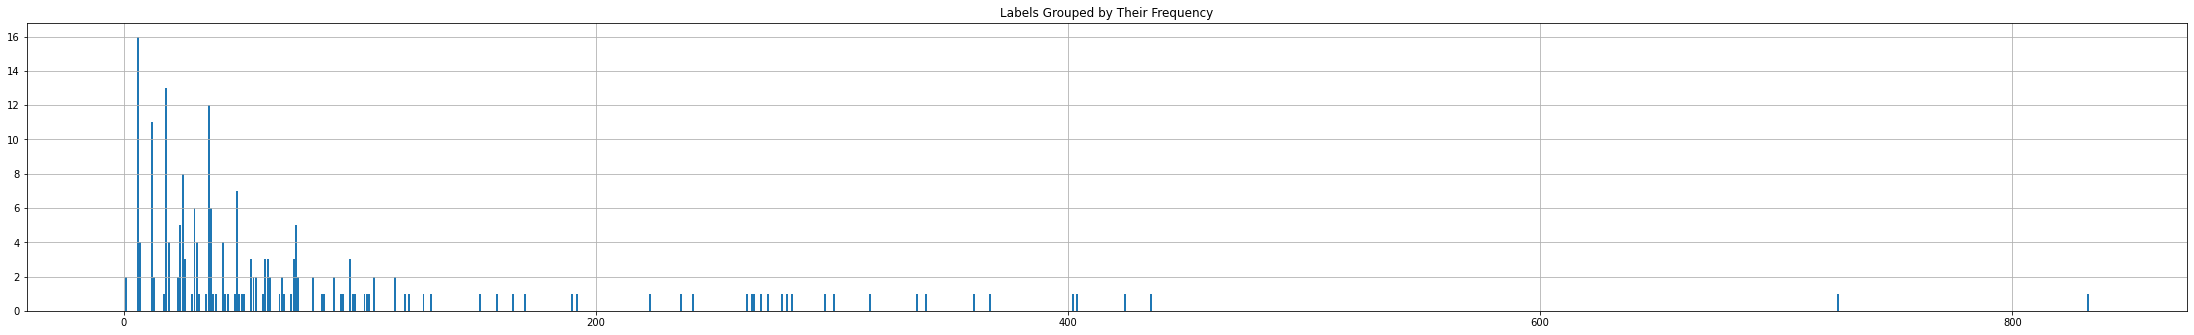

In [6]:
group_names = list(set(label_frequency))
group_frequency = [list(label_frequency).count(i) for i in group_names]

fig = plt.figure(200)
ax = fig.add_axes([0,0,5,1])
ax.bar(group_names,group_frequency)
plt.grid()
plt.title('Labels Grouped by Their Frequency')
plt.show()

In [7]:
final_label_counts = [list(label_frequency)[i] for i in range(0, len(label_frequency)) if list(label_frequency)[i] > 130]
pindex = list(label_frequency).index(final_label_counts[0])
final_label_names = list(label_names)[pindex:]
print(final_label_names)
print(len(final_label_names))

['pi3k_inhibitor', 'estrogen_receptor_agonist', 'gaba_receptor_antagonist', 'vegfr_inhibitor', 'acetylcholine_receptor_agonist', 'bacterial_cell_wall_synthesis_inhibitor', 'raf_inhibitor', 'serotonin_receptor_agonist', 'histamine_receptor_antagonist', 'phosphodiesterase_inhibitor', 'glucocorticoid_receptor_agonist', 'sodium_channel_inhibitor', 'adrenergic_receptor_agonist', 'kit_inhibitor', 'flt3_inhibitor', 'calcium_channel_blocker', 'hmgcr_inhibitor', 'pdgfr_inhibitor', 'acetylcholine_receptor_antagonist', 'tubulin_inhibitor', 'egfr_inhibitor', 'cdk_inhibitor', 'adrenergic_receptor_antagonist', 'glutamate_receptor_antagonist', 'dna_inhibitor', 'serotonin_receptor_antagonist', 'dopamine_receptor_antagonist', 'cyclooxygenase_inhibitor', 'proteasome_inhibitor', 'nfkb_inhibitor']
30


In [8]:
from sklearn import preprocessing

def generate_binary_pair(dataset, labels, pref_label):
    class_columns = pd.get_dummies(dataset[['cp_type', 'cp_time', 'cp_dose']].astype(str))
    trainxc = pd.concat([dataset, class_columns], axis=1).drop(['cp_type', 'cp_time', 'cp_dose'], axis=1)
    trainyc = labels
    label_names = list(trainyc.columns)[1:]
    
    trainxc = trainxc.drop(columns=trainxc.columns[0], axis=1).to_numpy()
    trainyc = trainyc.drop(columns=trainyc.columns[0], axis=1).to_numpy()
    
    min_max_scaler = preprocessing.MinMaxScaler()
    trainxc = min_max_scaler.fit_transform(trainxc)
    
    train_dataset = []
    one_hot = [0 for _ in range(len(label_names))]
    if pref_label != 'none':
        one_hot[label_names.index(pref_label)] = 1
    
    index = list(one_hot).index(1)
    for idx, label in enumerate(trainyc):
        if list(label)[index] == 1:
            given_label = 1
        else:
            given_label = 0
        train_dataset.append([trainxc[0], np.asarray([given_label])])
    
    return trainxc, trainyc, label_names, train_dataset

In [9]:
binary_dataset = {}
for label in final_label_names:
    var_name = f"{label}_binary_dataset"
    _, _, _, gen_dataset = generate_binary_pair(train_features, train_targets_scored, str(label))
    binary_dataset[var_name] = gen_dataset

In [28]:
all_finds = [value[20][1] for value in binary_dataset.values()]
print(all_finds)
print(list(binary_dataset.keys())[7]) #entry 3 in dataset belongs to pdgfr_inhibitor
print(list(binary_dataset.keys())[13]) #entry 3 in dataset belongs to kit_inhibitor

#after seeing which labels have labelled the 3rd datapoint in our dataset with 1 as true, the dataset has corresponding values for the respective labels, thus the script worked sucessfully

[array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0])]
serotonin_receptor_agonist_binary_dataset
kit_inhibitor_binary_dataset


In [72]:
## We can now format the data, but now comes selecting the most appropriate model for binary classification. This is fundamentally a binary classification problem, and with 879 parameters, it is very certain that we're going to see overfitting in
## in the dataset, so we should try to reduce the dimensionality for this reason and the fact that we will be creating up to 30 independent models for testing. 

import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch

from torch.utils.data import Dataset, DataLoader

class BinaryForwardNN(nn.Module):
    def __init__ (self):
        super().__init__()
        self.fc1 = nn.Linear(879, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 600)
        self.bn3 = nn.BatchNorm1d(600)
        self.fc3 = nn.Linear(600, 300)
        self.bn2 = nn.BatchNorm1d(300)
        
        self.drop = nn.Dropout(0.3)
        self.output = nn.Linear(300, 1)
        
        nn.init.xavier_uniform_(self.fc1.weight) 
        nn.init.xavier_uniform_(self.fc2.weight) 
        nn.init.xavier_uniform_(self.fc3.weight)  

    
    def forward(self, x):
        x = x.float()
        x = F.relu_(self.drop(self.bn1(self.fc1(x))))
        x = F.relu_(self.drop(self.bn1(self.fc2(x))))
        x = F.relu_(self.drop(self.bn3(self.fc4(x))))
        x = F.relu_(self.drop(self.bn2(self.fc3(x))))
        output = F.sigmoid(self.output(x))
        
        return output
    
main_model = BinaryForwardNN()

# EXAMPLE: Serotonin_Receptor_Agonist Binary Model

In [73]:
## Quickly check out the data
for label in binary_dataset.keys():
    labels = [i[1] for i in binary_dataset[label]]
#     print(f"{label} -> Total Items = {len(labels)} -> True Labels = {labels.count(np.array(1))}")
    

## Because there are just a few actual labels, we need to splut the true labels and true negatives by an equal amount
def partition_trues(dataset, split_train_val):
    true_positives = [i for i in dataset if i[1] == np.array(1)]
    true_negatives = [i for i in dataset if i[1] == np.array(0)]
    np.random.shuffle(true_positives)
    np.random.shuffle(true_negatives)
    
    train_tp_idx = int(len(true_positives)*split_train_val)-1
    train_tn_idx = int(len(true_negatives)*split_train_val)-1
    
    train_tp = true_positives[:train_tp_idx]    
    train_tn = true_negatives[:train_tn_idx]
    
    val_tp = true_positives[train_tp_idx:] 
    val_tn = true_negatives[train_tn_idx:]
    
    train_dataset = train_tp + train_tn
    np.random.shuffle(train_dataset)

    valid_dataset = val_tp + val_tn
    np.random.shuffle(valid_dataset)
    
    return train_dataset, valid_dataset



In [82]:
BATCH_SIZE = 128
EPOCHS = 2
lr_sched = 1e-2
optimizer = optim.SGD(main_model.parameters(), lr=lr_sched)
loss_fn = nn.BCELoss()

train_dataset, valid_dataset = partition_trues(binary_dataset['nfkb_inhibitor_binary_dataset'], 0.8)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=BATCH_SIZE)

def TrainLoop(train_loader, model, lr_sched = 1e-2):
    model.train()
    final_train_loss = 0
    print(lr_sched)
    lr_sched *= 0.8
    for idx, data in enumerate(train_loader):
        optimizer = optim.SGD(main_model.parameters(), lr=lr_sched)
        optimizer.zero_grad()
        inputs = data[0]
        targets = data[1]

#             print(inputs.shape)
#             print(targets.shape)
        targets = data[1].view(-1)
        outputs = model(inputs).view(-1)
        loss = loss_fn(outputs, targets.type_as(outputs))
        loss.backward()
        optimizer.step()
        final_train_loss += loss.item()

    final_train_loss = final_train_loss/len(train_loader)

    return final_train_loss
            
def ValidLoop(valid_loader, model):
    min_valid_loss = np.inf
    
    with torch.no_grad():
        final_val_loss = 0

        for idx, data in enumerate(valid_loader):
            inputs = data[0]
            targets = data[1].view(-1)
            outputs = model(inputs).view(-1)
            loss = loss_fn(outputs, targets.type_as(outputs))
            final_val_loss += loss.item()

        final_val_loss = final_val_loss/len(valid_loader)
    
    return final_val_loss
    
    if final_val_loss < min_valid_loss:
        min_valid_loss = final_val_loss
    
def MainLoop(model, epochs, train_loader, valid_loader):
    train_losses = []
    valid_losses = []
    
    for epoch in range(epochs):
        final_val_loss = ValidLoop(valid_loader, model)
        final_train_loss = TrainLoop(train_loader, model)
        train_losses.append(final_train_loss)
        valid_losses.append(final_val_loss)
        
        print(f"Epoch {epoch} | Training Loss: {final_train_loss} | Validation Loss: {final_val_loss} |")
    
    return train_losses, valid_losses

In [83]:
train_losses, valid_losses = MainLoop(main_model, EPOCHS, train_loader, valid_loader)

0.01
Epoch 0 | Training Loss: 0.15118338847720383 | Validation Loss: 0.15241552144289017 |
0.01
Epoch 1 | Training Loss: 0.1514244698638084 | Validation Loss: 0.15241557222447896 |


In [101]:
count = 0
correct = 0

for idx, item in enumerate(train_loader):
    count += 1
    inp = item[0]
    label = item[1].view(-1)
    output = main_model(inp).view(-1)
    
#     print(label)
#     print(np.where(output == max(output), 0, 1))
    